In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import ftfy

from doctest import DocTestParser, Example
from crawlercrawler.normalization import normalize, NORMALIZE_LABEL

%config InlineBackend.figure_format = 'retina'

In [2]:
plt.style.use('seaborn-paper')
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [3]:
def remove_examples(docstring):
    p = DocTestParser()
    not_tests = []
    num_tests = 0
    try:
        for example in p.parse(docstring):
            if isinstance(example, str):
                not_tests.append(example)
            else:
                num_tests += 1
        return ''.join(not_tests), num_tests
    except ValueError:
        return docstring, -1

NORMALIZE_LABEL.pop('user_handle', None)  # conflicts with javadoc style

def clean(docstring):
    cleaned = normalize(ftfy.ftfy(docstring), norm_label=NORMALIZE_LABEL)
    if len(cleaned) < 0.5 * len(docstring):
        return ''
    return cleaned

In [4]:
from crawlercrawler import load_zip_json

In [5]:
dat = load_zip_json('/smartml-athena/processed-data/fundef-docstrings/python-func-def-docstrings-2020-03-04-2336.json.gz')

In [6]:
signature_lengths, no_doc_signature_lengths = [], []
docstring_lengths = []
body_lengths, no_doc_body_lengths = [], []

signature_lines, no_doc_signature_lines = [], []
docstring_lines = []
body_lines, no_doc_body_lines = [], []

docstrings = []

failed_doctring_parse = 0
number_of_examples = 0
docstrings_with_examples = 0

for d in dat:
    for example in d[1]:
        cleaned_docstring, n_examples = remove_examples(clean(example[1]))

        if len(cleaned_docstring) > 0:
            if n_examples < 0:
                failed_doctring_parse += 1
            elif n_examples > 0:
                number_of_examples += n_examples
                docstrings_with_examples += 1
                
            signature_lengths.append(len(example[0]))
            docstring_lengths.append(len(example[1]))
            body_lengths.append(len(example[2]))
            docstrings.append(cleaned_docstring)
            
            signature_lines.append(len(example[0].splitlines()))
            docstring_lines.append(len(example[1].splitlines()))
            body_lines.append(len(example[2].splitlines()))
        else:
            no_doc_signature_lengths.append(len(example[0]))
            no_doc_body_lengths.append(len(example[2]))
            
            no_doc_signature_lines.append(len(example[0].splitlines()))
            no_doc_body_lines.append(len(example[2].splitlines()))

In [756]:
test_indices = []
i = 0
for d in dat:
    for example in d[1]:
        cleaned_docstring, n_examples = remove_examples(clean(example[1]))
        if len(cleaned_docstring) > 0:
            if 'test' in (example[0] + cleaned_docstring).casefold():
                test_indices.append(i)
            i += 1

In [13]:
total_length = sum(map(lambda x: sum(map(lambda y: len(y[1]), x[1])), dat))
cleaned_length = sum(map(len, docstrings))
print(cleaned_length/total_length)

0.9438643088594021


In [7]:
print(f'Number of methods {sum(map(lambda x: len(x[1]), dat))}')
print(f'Number of docstrings {len(docstrings)}')
print(f'Number of docstrings with an example {docstrings_with_examples}')
print(f'Number of examples {number_of_examples}')
print(f'Number of failed doctest parses {failed_doctring_parse}')

Number of methods 26271621
Number of docstrings 7576925
Number of docstrings with an example 182183
Number of examples 890262
Number of failed doctest parses 2007


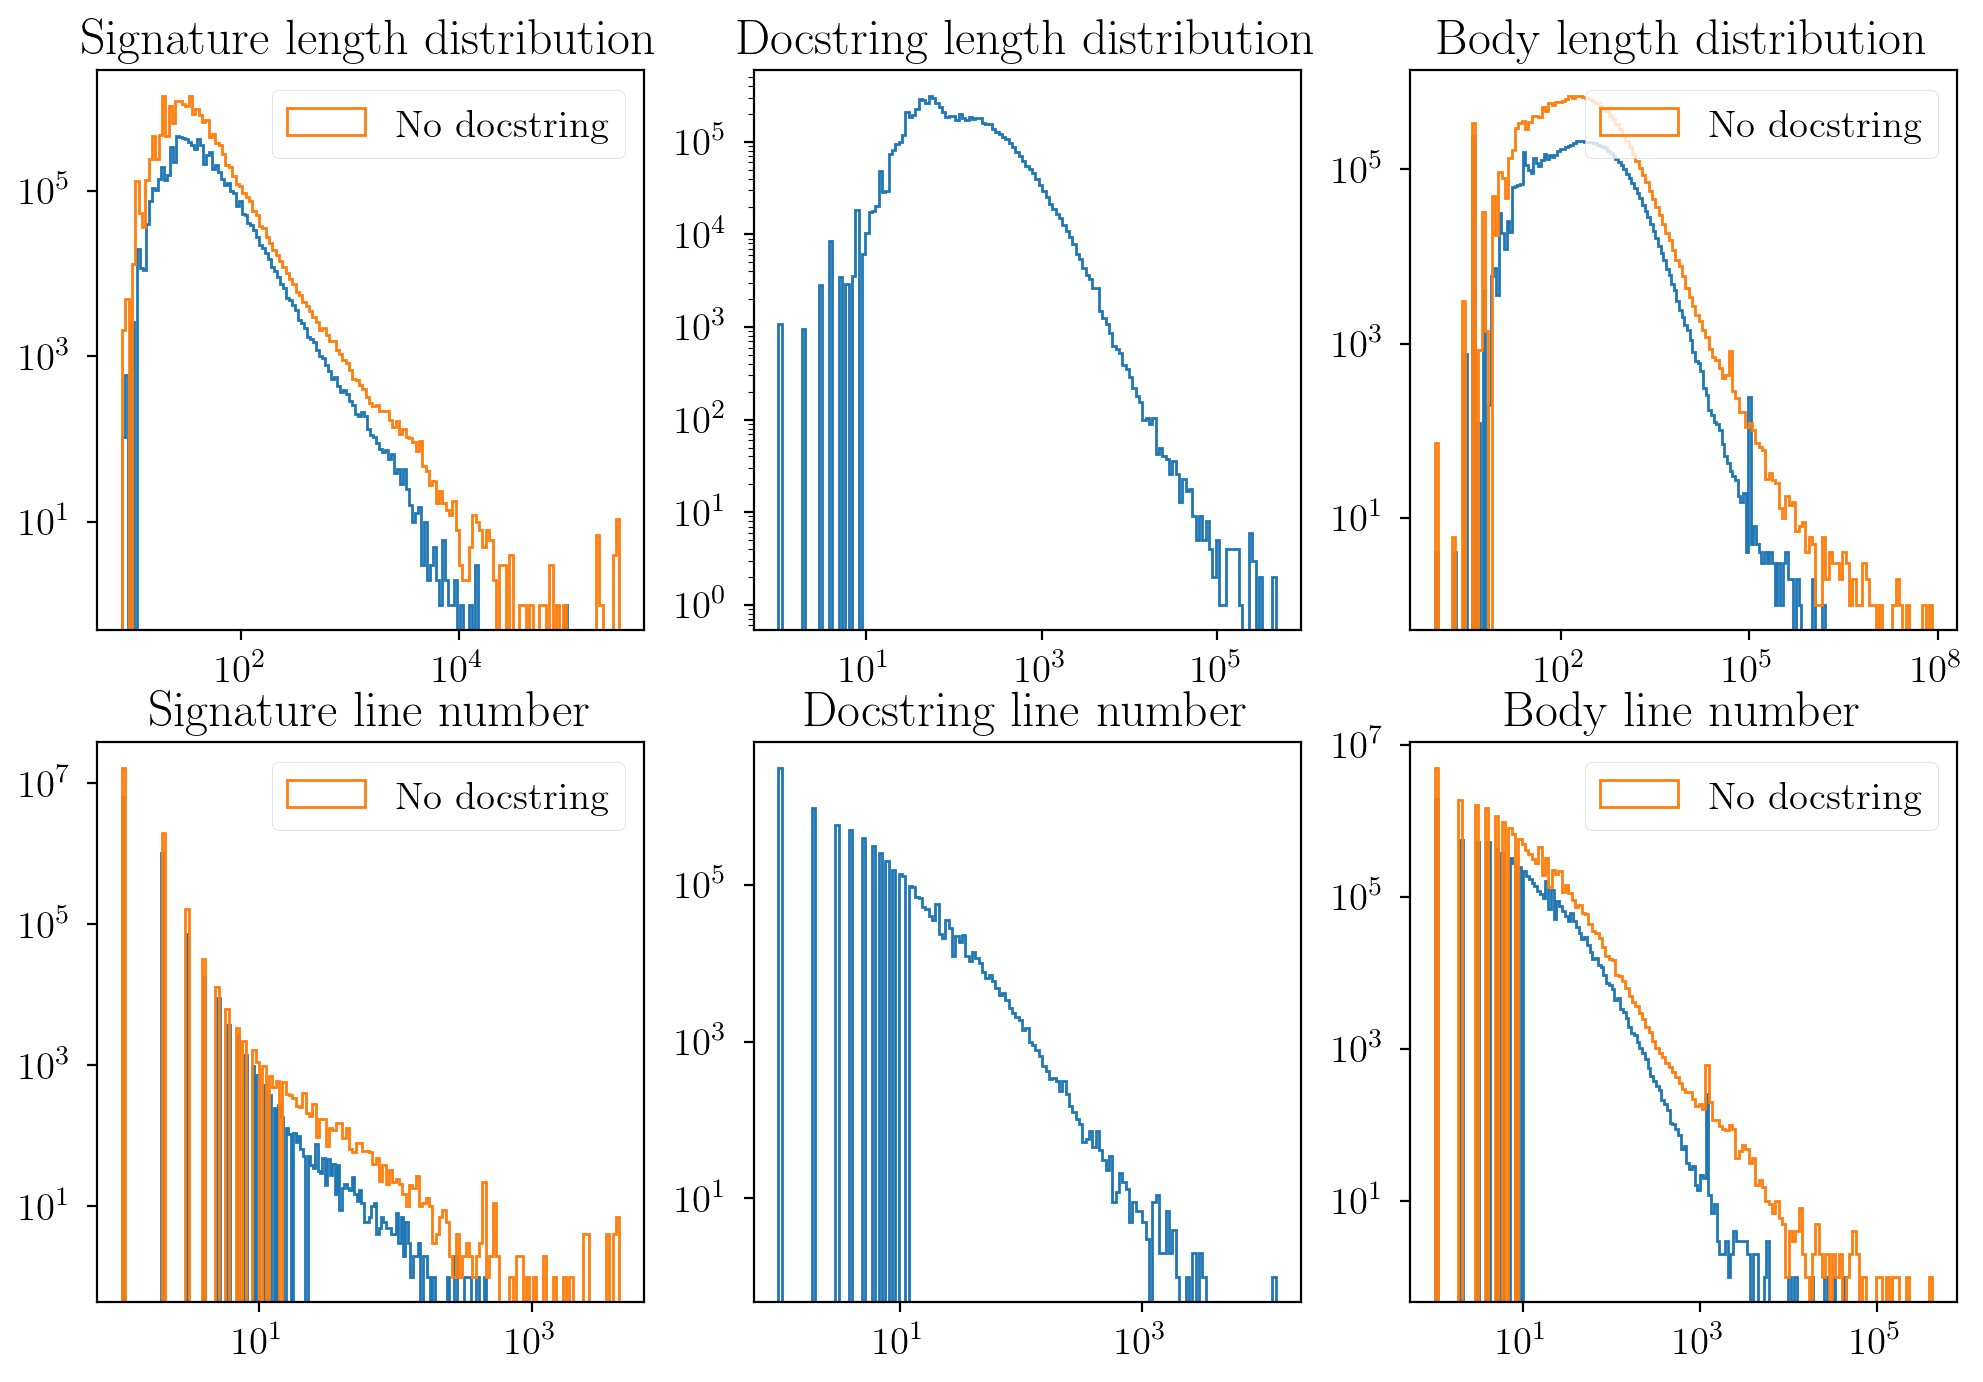

In [856]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))


plot_dict = {
    'Signature': {None: signature_lengths, 'No docstring': no_doc_signature_lengths},
    'Docstring': {None: docstring_lengths},
    'Body': {None: body_lengths, 'No docstring': no_doc_body_lengths},
}

for ax, (title, d) in zip(axes[0], plot_dict.items()):

    for label, data in d.items():
        if data is not None:

            bins = np.logspace(np.log10(max(min(data), 1)), np.log10(max(data)), 150)
            ax.hist(data, bins=bins, histtype='step', label=label, lw=1.)
            if label:
                ax.legend(loc='upper right')
    ax.set_title(f"{title} length distribution")
    ax.set_yscale('log')
    ax.set_xscale('log')

    
plot_dict = {
    'Signature': {None: signature_lines, 'No docstring': no_doc_signature_lines},
    'Docstring': {None: docstring_lines},
    'Body': {None: body_lines, 'No docstring': no_doc_body_lines},
}

for ax, (title, d) in zip(axes[1], plot_dict.items()):

    for label, data in d.items():
        if data is not None:

            bins = np.logspace(np.log10(max(min(data), 1)), np.log10(max(data)), 150)
            ax.hist(data, bins=bins, histtype='step', label=label, lw=1.)
            if label:
                ax.legend(loc='upper right')
    ax.set_title(f"{title} line number")
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.show()

In [859]:
(sum(signature_lengths) + sum(docstring_lengths) + sum(body_lengths)) / 1e9

5.087964011

In [860]:
(sum(no_doc_signature_lengths) + sum(no_doc_body_lengths)) / 1e9

8.155901495

In [849]:
len(dat)

2388212

In [848]:
sum(body_lengths) * 8 / 1e9

25.59432132

In [10]:
import fasttext
from sklearn.manifold import TSNE
from tokenizers import ByteLevelBPETokenizer

from pathlib import Path

In [11]:
DATADIR = Path('/smartml-athena/processed-data/fundef-docstrings/split/')
VOCAB = DATADIR / 'python-func-def-docstrings-2019-12-19-2307-3165559177_bytelevelbpe_30000-vocab.json'
MERGES = DATADIR / 'python-func-def-docstrings-2019-12-19-2307-3165559177_bytelevelbpe_30000-merges.txt'
tokenizer = ByteLevelBPETokenizer(str(VOCAB), str(MERGES))

In [626]:
#rm /bigdata/scratch/docstrings-tokenized.txt

In [48]:
dt = Path('/bigdata/scratch/docstrings-tokenized-2.txt')
if not dt.exists():
    with open(dt, 'w') as fout:
        for t in tokenizer.encode_batch(docstrings):
            if t:
                fout.write(' '.join(t.tokens))
                fout.write('\n')

In [96]:
#rm /bigdata/scratch/docstrings-fasttext.bin

In [12]:
mp = Path('/bigdata/scratch/docstrings-fasttext.bin')
model = fasttext.load_model(str(mp))
# if not mp.exists():
#     model = fasttext.train_unsupervised(
#         '/bigdata/scratch/docstrings-tokenized.txt',
#         model='skipgram',
#         wordNgrams=1,
#         verbose=2,
#         dim=100,
#         minCount=10,
#         lr=0.2,
#     )
#     model.save_model('/bigdata/scratch/docstrings-tokenized-fasttext-model.bin')
# else:
#     model = fasttext.load_model(str(mp))

In [49]:
with open('/bigdata/scratch/docstrings-tokenized-2.txt') as fin:
    tokenized_docstrings = fin.readlines()

In [50]:
len(tokenized_docstrings)

7576925

In [51]:
len(docstrings)

7576925

In [52]:
some_docstrings = tokenized_docstrings[::10]
embeddings = np.array([
    model.get_sentence_vector(d.replace('\n', ' ')) for d in some_docstrings
])

In [15]:
from scipy.sparse.linalg import svds

In [53]:
u, s, vt = svds((embeddings - embeddings.mean(0)[None,:])/embeddings.std(0)[None,:], k=99)

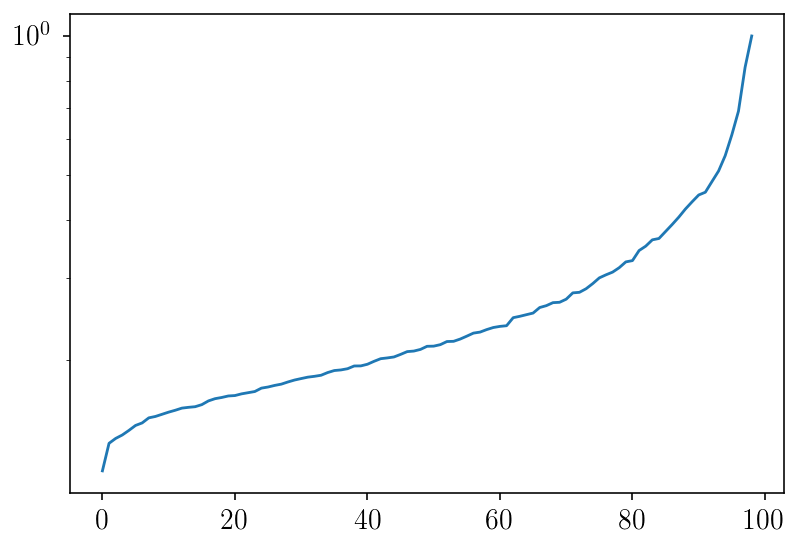

In [54]:
plt.plot(s/s.max());plt.yscale('log')

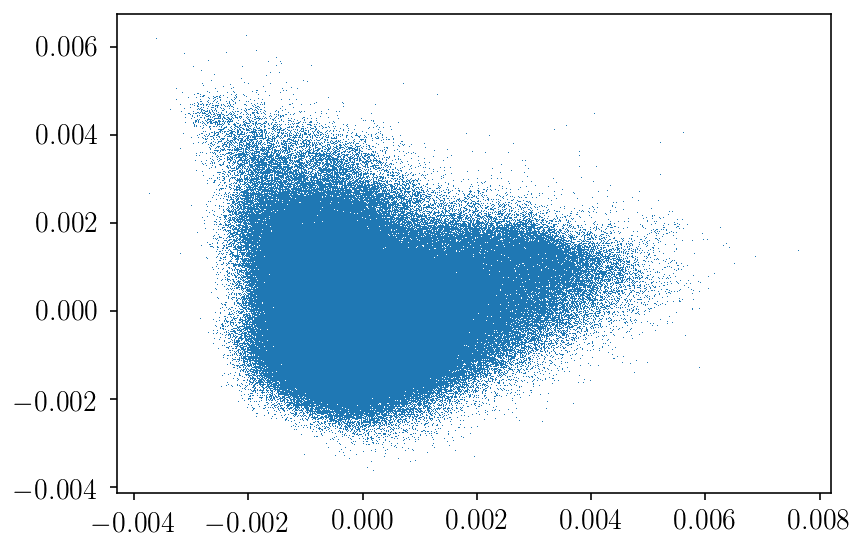

In [55]:
plt.plot(u[:,-1], u[:,-2], ',')

In [18]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [19]:
from sklearn.manifold import TSNE as skTSNE

In [705]:
skTSNE?

In [56]:
compressed_embedding = TSNE(
    n_components=2, 
    perplexity=35.,
    early_exaggeration=16,
    init=u[:,-2:],
    learning_rate=750,
    n_iter=1500,
    n_jobs=20
).fit_transform(embeddings)

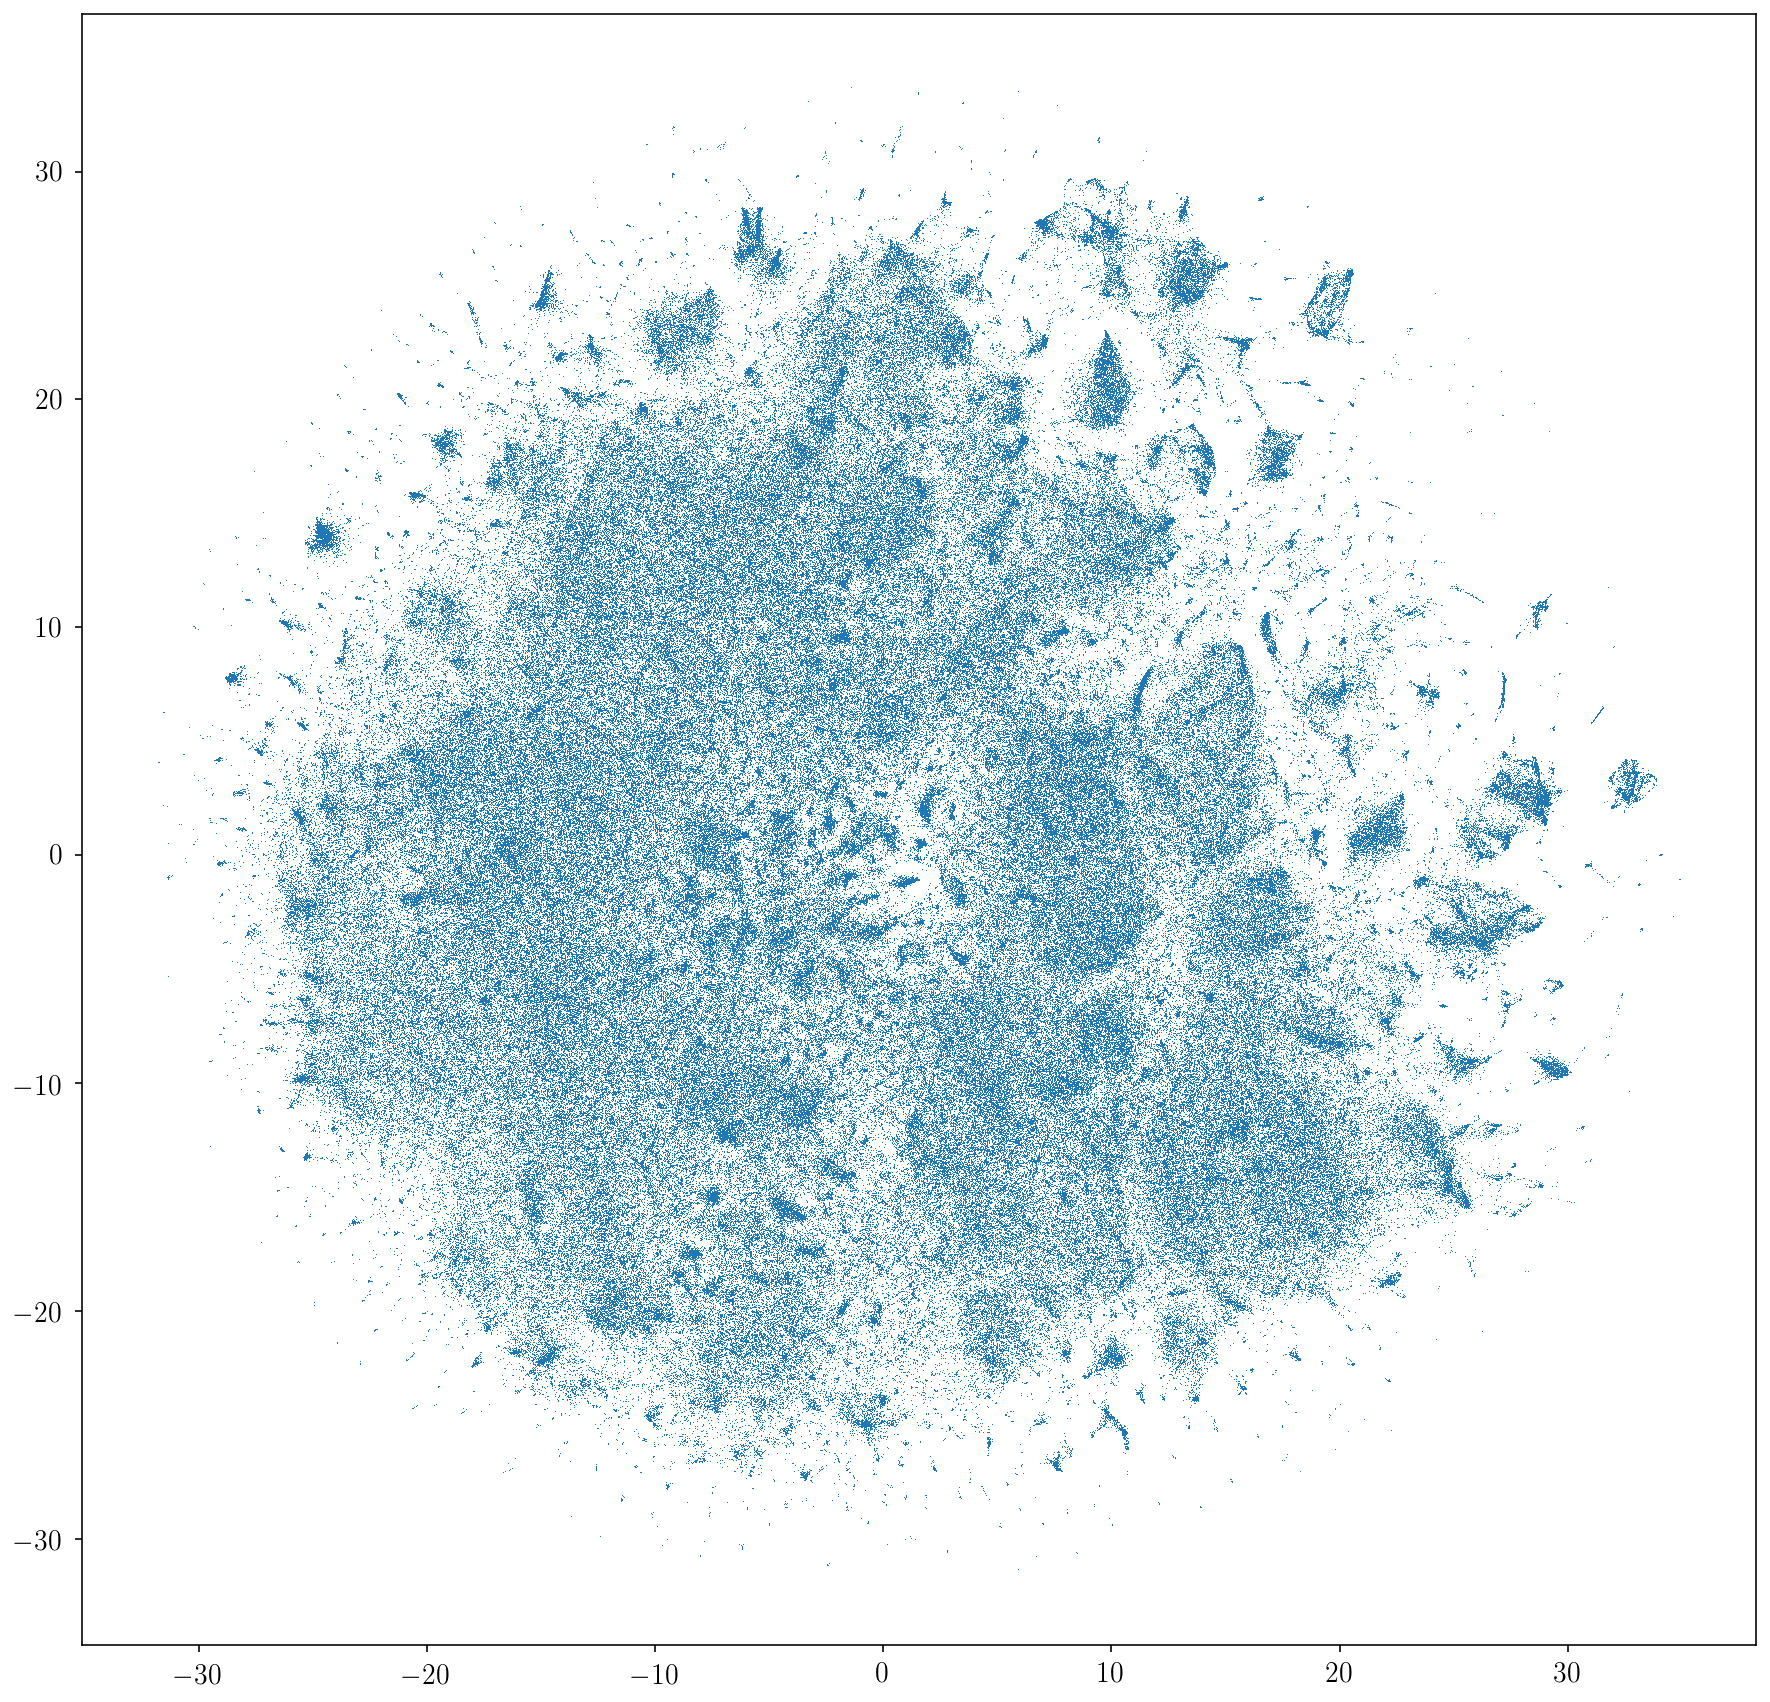

In [57]:
fig, axe = plt.subplots(figsize=(15,15))
axe.plot(*compressed_embedding.T, ',')
plt.show()

In [22]:
import re

def detect_numpydoc(docstring):
    """Return True if numpydoc detected"""
    ALLOWED_SECTIONS = {
        "Parameters",
        "Attributes",
        "Methods",
        "Returns",
        "Yields",
        "Other Parameters",
        "Raises",
        "Warns",
        "See Also",
        "Notes",
        "References",
        "Examples",
        }
    lines = docstring.splitlines()
    for i, line in enumerate(lines):
        if line.strip() in ALLOWED_SECTIONS:
            if i + 1 < len(lines) and set(lines[i + 1].strip()) == set('-'):
                return True
            # relaxation of numpydoc but a common user pattern
            elif i + 1 < len(lines) and set(lines[i + 1].strip()) == set('='):
                return True
    return False

RE_REST_PARAM = re.compile(r'^(:(?:param|type|raises) [\S]+[ \S]*:)[\S ]*$', flags=re.M | re.I)
RE_REST_RETURN = re.compile(r'^(:(?:return|returns|rtype):)[\S ]*$', flags=re.M | re.I)

def detect_reST(docstring):
    return (
        bool(RE_REST_PARAM.search(docstring)) or 
        bool(RE_REST_RETURN.search(docstring))
    )

RE_JAVADOC_PARAM = re.compile(r'^(@(?:param|raises) [\S]+:)[\S ]*$', flags=re.M | re.I)
RE_JAVADOC_RETURN = re.compile(r'^(@(?:return|returns|rtype):)[\S ]*$', flags=re.M | re.I)

def detect_javadoc(docstring):
    return (
        bool(RE_JAVADOC_PARAM.search(docstring)) or
        bool(RE_JAVADOC_RETURN.search(docstring))
    )

RE_GOOGLE_SECTION = re.compile(r'^(?:Args|Returns|Yields|Raises):$', flags=re.M)

def detect_google(docstring):
    return bool(RE_GOOGLE_SECTION.search(docstring))

def detect_oneline(docstring):
    return bool(len(list(filter(lambda x: x, docstring.splitlines()))) == 1)

def detect_oneparagraph(docstring):
    lines = docstring.splitlines()
    if len(lines) > 1:
        return all(docstring.splitlines())
    return False

    
DOCSTRING_TYPES = {  # order matters
    'oneline': detect_oneline,
    'numpydoc': detect_numpydoc,
    'google': detect_google,
    'reST': detect_reST,
    'javadoc': detect_javadoc,
    'oneparagraph': detect_oneparagraph,
}

def multi_classify(docstring):
    labels = []
    docstring = docstring.strip()
    for label, detector in DOCSTRING_TYPES.items():
        if detector(docstring):
            labels.append(label)
    if len(labels) == 0:
        labels.append('other')
    return tuple(labels)

def classify(docstring):
    label = 'other'
    docstring = docstring.strip()
    for lab, detector in DOCSTRING_TYPES.items():
        if detector(docstring):
            label = lab
            break
    return label

In [24]:
subset_docstrings = docstrings[::10]
classified, m_classified = [], []
for d in docstrings:
    classified.append(classify(d))
    m_classified.append(multi_classify(d))

In [33]:
some_test_indices = []
test_indices_set = set(test_indices)
for i, d in enumerate(docstrings):
    if i % 10 == 0 and i in test_indices_set:
        some_test_indices.append(i // 10)

NameError: name 'test_indices' is not defined

In [26]:
from collections import Counter, defaultdict

In [41]:
counter = Counter()
m_counter = Counter()
test_counter = Counter()

In [42]:
for c in classified:
    counter.update([c])
    
for m_c in m_classified:
    m_counter.update([m_c])
    
#or i in some_test_indices:
#    test_counter.update([classified[i]])

In [909]:
for l, n in m_counter.items():
    if any('oneline' in ll for ll in l):
        print(f'{l}: \t\t{n/sum(m_counter.values())*100}')

('oneline',): 		41.08345499618511
('oneline', 'reST'): 		0.3442640695497903
('oneline', 'javadoc'): 		0.038280897304232814
('oneline', 'google'): 		0.002244052600592958


In [1008]:
for l, n in counter.items():
    print(f'{l}: \t\t{n/sum(counter.values())*100}')

numpydoc: 		4.75566290048589
oneparagraph: 		13.8301376040036
oneline: 		44.49926533668251
other: 		14.856052586871577
reST: 		13.163983901428525
javadoc: 		1.6247602988497645
google: 		7.270137371678125


In [809]:
print(len(test_indices)/len(docstrings) * 100)
for l, n in test_counter.items():
    print(f'{l}: \t\t{n/len(docstrings)*100}')

12.937123353871696
numpydoc: 		0.20368077427734907
oneline: 		7.79557472827163
oneparagraph: 		2.6741186813418905
other: 		1.3892005628611934
reST: 		0.5024037763445175
javadoc: 		0.055705305732366366
google: 		0.3434720509848751


In [810]:
for l, n in test_counter.items():
    print(f'{l}: \t\t{n/counter[l]*100}')

numpydoc: 		4.480125431898029
oneline: 		18.798902421167227
oneparagraph: 		16.14041797133319
other: 		8.880563009467874
reST: 		3.8936858043131317
javadoc: 		3.4778308884127243
google: 		4.72472399767577


In [43]:
collect = defaultdict(list)
grouped = {k: [] for k in counter}
for i, (doc, cls) in enumerate(zip(docstrings[::10], classified[::10])):
    collect[cls].append(doc)
    grouped[cls].append(i)

In [45]:
compressed_embedding.shape

(757558, 2)

In [44]:
for k, v in grouped.items():
    print(k, max(v))

numpydoc 757499
oneparagraph 757691
oneline 757692
reST 757644
other 757664
javadoc 757544
google 757601


In [781]:
bar = docstrings
foo = [bar[i] for i in np.array(test_indices)]

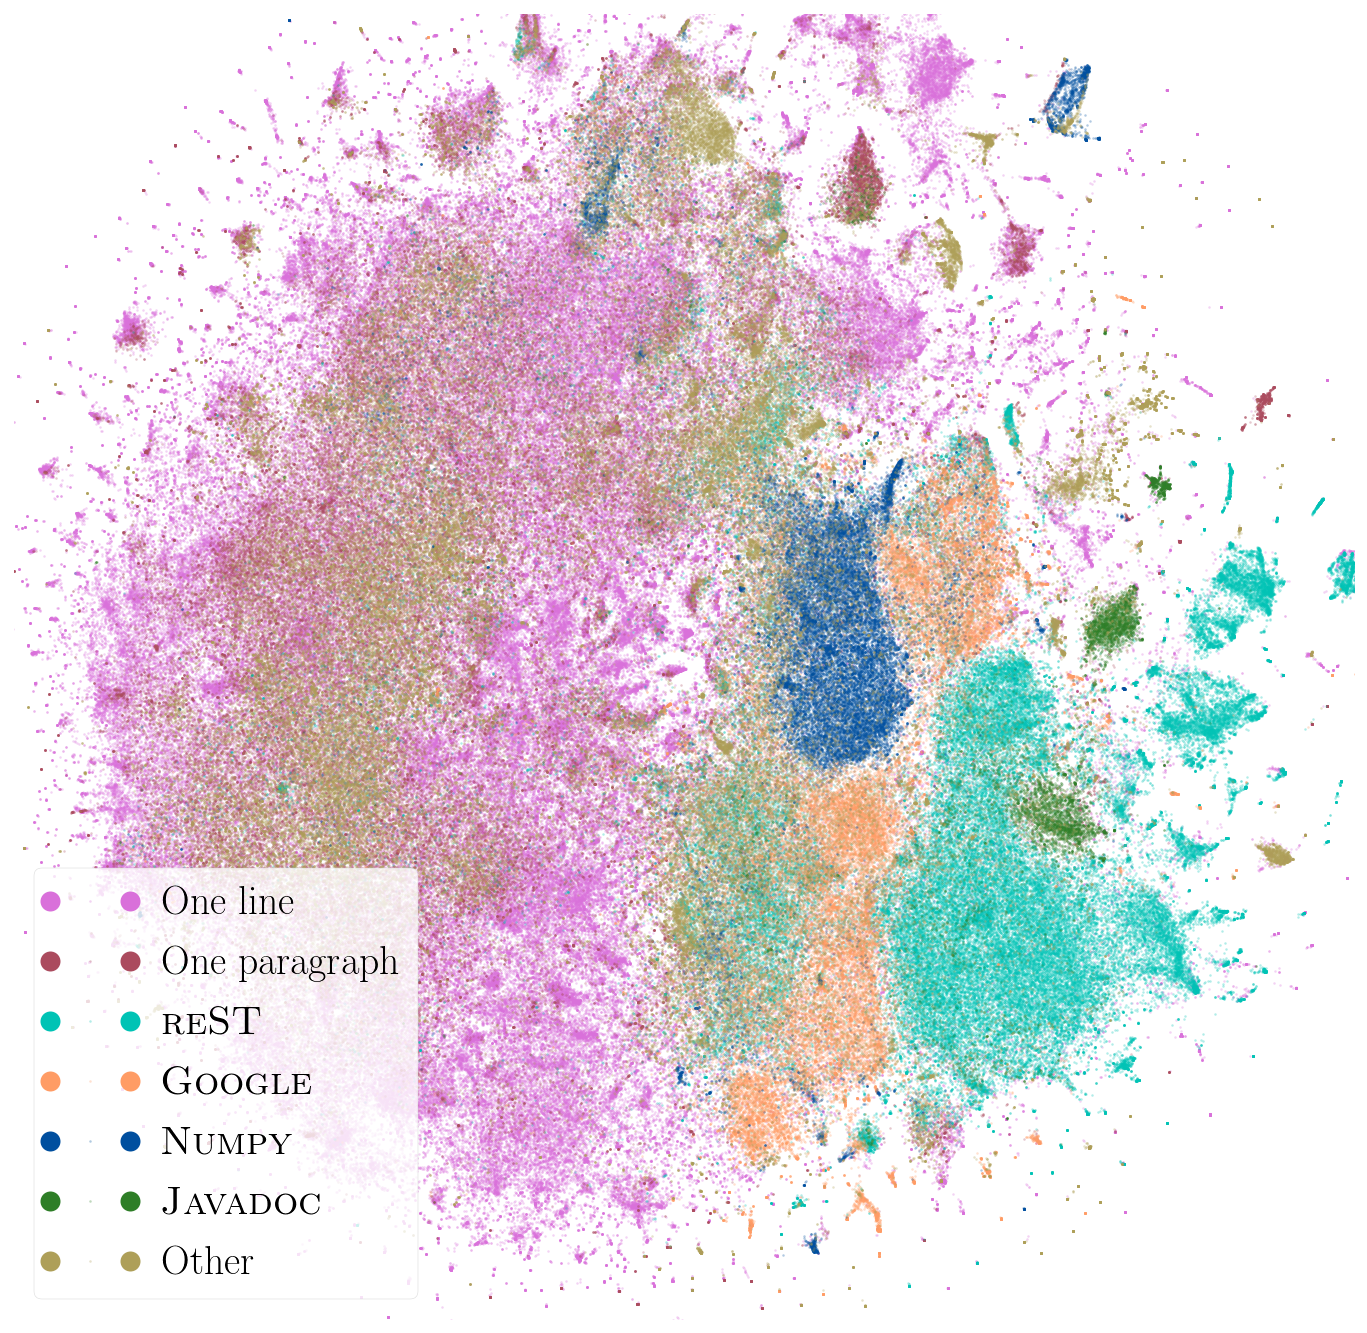

<Figure size 460.8x316.8 with 0 Axes>

In [72]:
colors = ["#d970da",
          "#ab4b5e",

"#00c3b5",
"#ff9c65",
"#004f9f",
"#2e7e27",
"#ae9f58"]

# re-ordered
# colors = [
#         "#d970da",
#         "#00c3b5",
#         "#2e7e27",
#         "#ff9c65",
#         "#004f9f",
#         "#ab4b5e",
#         "#ae9f58"
# ]

# colors = [
# "#c8b23f",
# "#bf003d",
# "#ff28be",
# "#7cef22",
# "#14ffe8",
# "#a16ad3",
# "#ff4f0e",
# ]

#plt.style.use('dark_background')
fig, axe = plt.subplots(figsize=(12,12))

#axe.plot(*compressed_embedding[np.array(some_test_indices)[::10]//10].T, '.', c='#ffffff', alpha=.7)

order = ['oneline', 'oneparagraph', 'reST', 'google', 'numpydoc', 'javadoc', 'other']
legend_label = {
    'oneline': "One line", 
    'oneparagraph': "One paragraph", 
    'reST': r"\textsc{reST}", 
    'google': r"\textsc{Google}", 
    'numpydoc': r"\textsc{Numpy}", 
    'javadoc': r"\textsc{Javadoc}", 
    'other': "Other"
}

for color, label in zip(colors, order):
    group = grouped[label]
    axe.plot(*compressed_embedding[np.array(group)].T, '.', markersize=2.5, c=color, label=legend_label[label], alpha=0.3)
    
axe.set_xlim([-30, 33])
axe.set_ylim([-30, 28])
    
leg = plt.legend(loc='lower left', markerscale=1, fontsize=20, frameon=True, facecolor='w')
for line in leg.get_lines():
    line.set_alpha(1.)
    line.set_marker('o')
    line.set_markersize(10)
    
axe.axis('off')
    
plt.show()
plt.draw()
#fig.savefig('docstring-style-tsne.png', dpi=300)

In [ ]:
line.set_mar

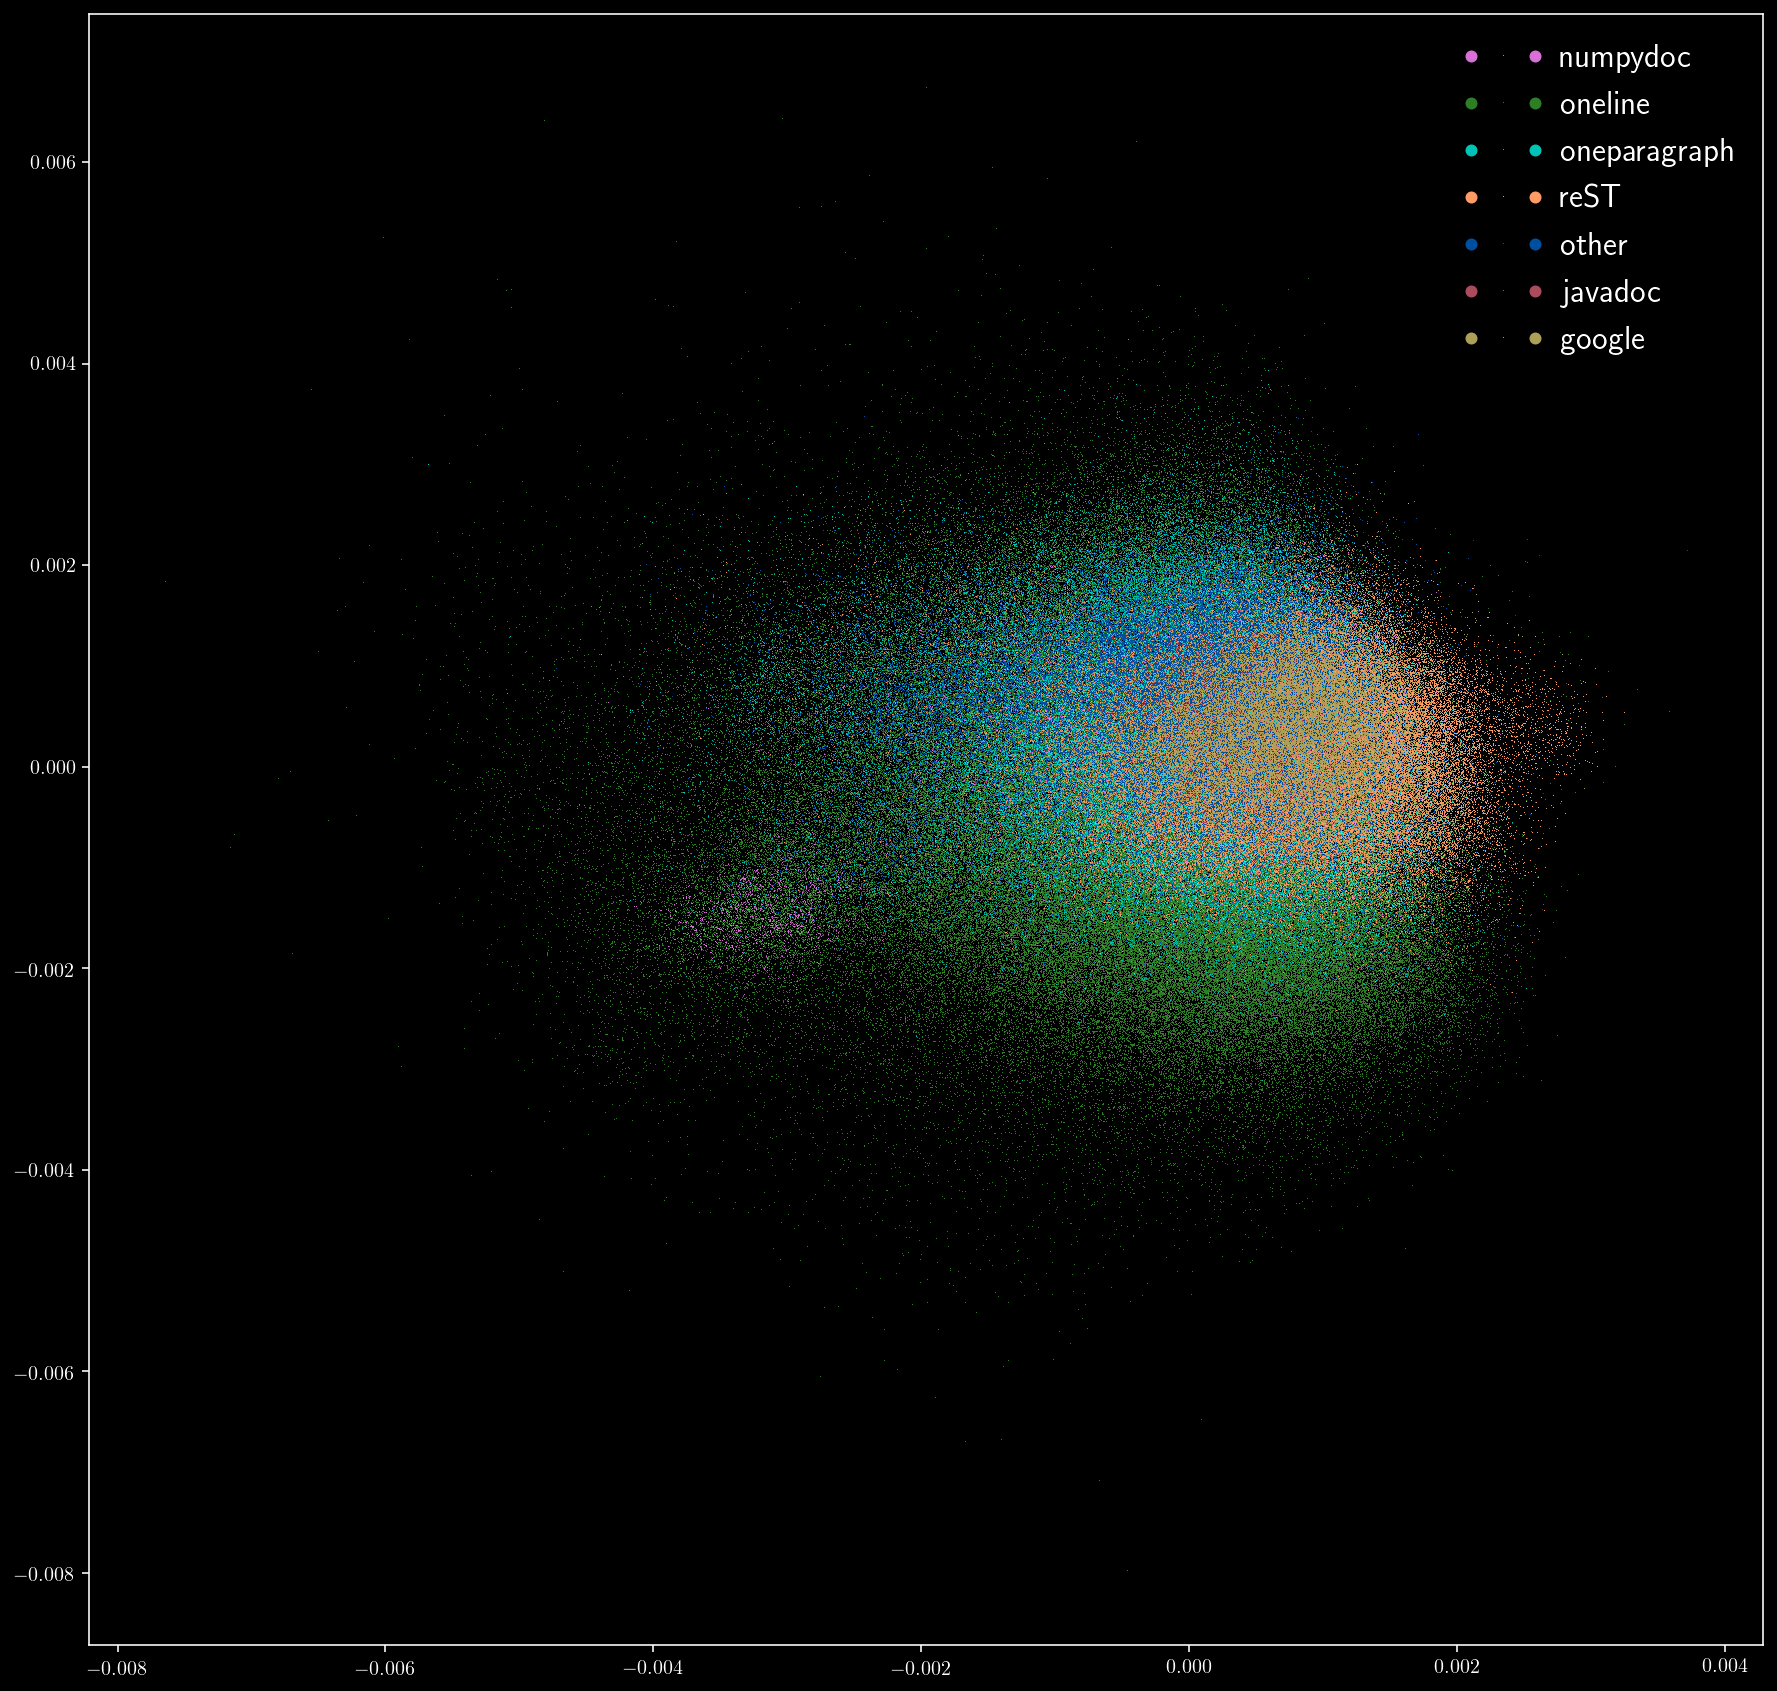

In [711]:
colors = ["#d970da",
"#2e7e27",
"#00c3b5",
"#ff9c65",
"#004f9f",
"#ab4b5e",
"#ae9f58"]

fig, axe = plt.subplots(figsize=(15,15))
for color, (label, group) in zip(colors, grouped.items()):
    axe.plot(u[np.array(group),-1], u[np.array(group),-4], ',', c=color, label=label, alpha=1.)

leg = plt.legend(loc='upper right', markerscale=5, fontsize=16)
for line in leg.get_lines():
    line.set_alpha(1.)
    line.set_marker('o')
plt.show()

In [580]:
lobe = np.arange(len(u))[u[:,-1] < -0.0045]

In [600]:
print(clean(docstrings[::10][lobe[6000]]))

Application 
        


In [450]:
cls = 'other'
n = np.random.randint(0, len(collect[cls]))
print(n)
d = collect[cls][n]
print(d)

1142971
Get movie names and times from BAM Rose Cinema's website

:theater: str
:date: str (yyyy-mm-dd) (default: today)
:returns: (list of movie names, list of lists of movie times)


In [446]:
rest = [280480]

In [284]:
RE_GOOGLE_SECTION.search(d)

<re.Match object; span=(168, 176), match='Returns:'>

In [309]:
import rstparse

In [313]:
p = rstparse.Parser()

In [320]:
p.parse_directive(d)

(None, None)

In [326]:
p.parse_indices(d)

TypeError: parse_indices() takes 1 positional argument but 2 were given

In [328]:
import tempfile

In [347]:
from docutils.parsers import rst

In [358]:
import docutils

In [426]:
settings = docutils.frontend.OptionParser(
                components=(docutils.parsers.rst.Parser,)
                ).get_default_values()
doc = docutils.utils.new_document('test', settings)
p.parse(d.replace('<user_handle>', 'param'), doc)

In [429]:
doc.children[1].children

[<#text: '@param  target: session.target\n@param target: Target we are rest ...'>]

In [394]:
doc.

KeyError: 'test'

In [412]:
c = doc.children[1]

In [414]:
doc

<document: <paragraph...><paragraph...><section "parameters"...><se ...>

In [424]:
print(d.replace('<user_handle>', 'param'))

Restart the fuzz target. If a VMControl is available revert the snapshot, if a process monitor is available
restart the target process. Otherwise, do nothing.

@param  target: session.target
@param target: Target we are restarting


In [425]:
d.replace('<user_handle>', 'param')

'Restart the fuzz target. If a VMControl is available revert the snapshot, if a process monitor is available\nrestart the target process. Otherwise, do nothing.\n\n@param  target: session.target\n@param target: Target we are restarting'

In [457]:
for d in docstrings:
    if '<guid>' in d:
        break

In [458]:
print(d)

Helper method that creates an atom id for a feed or entry.

An id must be unique, and must not change over time.  ie - once published,
it represents an atom feed or entry uniquely, and forever.  See [4]:

    When an Atom Document is relocated, migrated, syndicated,
    republished, exported, or imported, the content of its atom:id
    element MUST NOT change.  Put another way, an atom:id element
    pertains to all instantiations of a particular Atom entry or feed;
    revisions retain the same content in their atom:id elements.  It is
    suggested that the atom:id element be stored along with the
    associated resource.

resource_path
    The resource path that uniquely identifies the feed or element.  This
    mustn't be something that changes over time for a given entry or feed.
    And does not necessarily need to be resolvable.

    e.g.  could represent
    the feed of datasets belonging to the identified group.

authority_name
    The domain name or email address of the publi

In [960]:
others = [d for c, d in zip(classified, docstrings) if c == 'other']
print(len(others))
np.random.shuffle(others)

1125432


In [1001]:
ind = np.random.randint(0, len(others))
print(others[ind])

Return a string describing the specific type of this map,
to be used when printing .

EXAMPLES::

    sage: L = lie_algebras.sl(QQ, 3)
    sage: La = L.cartan_type().root_system().weight_lattice().fundamental_weights()
    sage: M = L.verma_module(La[1] + La[2])
    sage: Mp = L.verma_module(M.highest_weight().dot_action([1,2]))
    sage: phi = Hom(Mp, M).natural_map()
    sage: phi._repr_type()
    'Verma module'


In [929]:
detect_numpydoc(others[10])

True

In [986]:
num = 0
for oth in others:
    for sec in [
            ':param'
    ]:
        if sec in oth:
            num += 1
            break

In [988]:
num / len(docstrings)

0.0017668616484627776

In [956]:
'foo\n\nbar'.strip()

'foo\n\nbar'